#### Model taken from:
- [1] Offshore Pipelaying Dynamics. Gullik Anthon Jensen 
- [2] A nonlinear PDE formulation for offshore vessel pipeline installation. Gullik A. Jensen et al 
- [3] Modeling and Control of Offshore Pipelay Operations Based on a Finite Strain Pipe Model. Gullik A. Jensen 

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from datetime import datetime
from scipy.optimize import fsolve
from scipy.integrate import solve_ivp
from scipy import interpolate

In [2]:
import sys
sys.path.insert(0, "../../../../Ocean_Intella/PythonVehicleSimulator-master/src/python_vehicle_simulator")
sys.path.insert(0, "../../../../Ocean_Intella/PythonVehicleSimulator-master/src")

In [3]:
from python_vehicle_simulator.vehicles import *
from python_vehicle_simulator.lib import *
from python_vehicle_simulator.lib.gnc import ssa

In [4]:
mp = 96       #  (submerged pipe weight) [kg/m]

In [5]:
node_N = 50

In [6]:
mi = [mp for i in range(node_N)] 

In [7]:
# L - the hull length
# Xg - x-center of gravity
L = 84.6 # [m]
B= 12
H= 13
Xg = L/2 # [m]
mn = 27_162_500 #123000000 # mass of the vessel, [kg]  
# kp, kd=1.95e4,1.5e4

In [8]:
lx,ly,lz=L/2,B/2,H/2

In [9]:
vessel_mass=mn/L # mass over length of the vessel

In [10]:
diag_Irho = 1e2*np.array([1, 1, 2]) # [m^4]  , p.99 in [1]
# diag_Irho = 1e-2*np.array([0.5, 0.5, 1])  # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Irho_=np.diag(diag_Irho)

In [11]:
Irho_

array([[100.,   0.,   0.],
       [  0., 100.,   0.],
       [  0.,   0., 200.]])

In [12]:
# Fossen book p.181
def vessel_inertia_moment(mn, Xg, L):
    r = 0.25*L
    Ir = mn*r**2
    Iz=mn*Xg**2 + Ir
    return Iz

In [13]:
vessel_inertia = vessel_inertia_moment(mn, Xg, L)

In [14]:
vessel_inertia

60751987031.24999

In [15]:
def inert(mn, vessel_inertia, Irho_, cum_d_inv, Ws):
    V_rho=np.zeros(Irho_.shape)
    np.fill_diagonal(V_rho, vessel_inertia)
    cum_m=0
    cum_i=0
    fin_123=[]
    for i in range(node_N-1,-1,-1):
        cum_m+=Ws[i]*cum_d_inv[i]**2
        cum_i+=Irho_
        fin_123.append(V_rho+cum_m + cum_i)
    return np.array(fin_123[::-1])

In [16]:
lll = [225.56518176169666,
 225.56666125111053,
 225.5696202396424,
 225.57405874670005,
 225.57997680139619,
 225.58737444254686,
 225.59625171867356,
 225.60660868800304,
 225.61844541846622,
 225.63176198770017,
 225.64655848304906,
 225.66283500156428,
 225.6805916500017,
 225.69982854482856,
 225.72054581222017,
 225.74274358806272,
 225.76642201794883,
 225.79158125718783,
 225.81822147079842,
 225.84634283351636,
 225.8759455297893,
 225.90702975377832,
 225.93959570937227,
 225.97364361016668,
 226.00917367948318,
 226.04618615036563,
 226.08468126557727,
 226.1246592776104,
 226.1661204486828,
 226.20906505073324,
 226.25349336544267,
 226.29940568421313,
 226.34680230818745,
 226.39568354823808,
 226.4460497249786,
 226.49790116876304,
 226.55123821968485,
 226.60606122758307,
 226.6623705520452,
 226.72016656240044,
 226.77944963773572,
 226.84022016689133,
 226.90247854846268,
 226.96622519079838,
 227.03146051202393,
 227.0981849400066,
 227.16639891240425,
 227.2361028766249,
 227.30729728986748]

In [17]:
cum_d_inv=[10]
sum_=0
for i in range(len(lll)-1,-1,-1):
    sum_+=lll[i]
    cum_d_inv.append(sum_)
cum_d_inv=cum_d_inv[::-1]    

In [18]:
cum_d_inv

[11081.714702627025,
 10856.149520865329,
 10630.582859614218,
 10405.013239374575,
 10179.439180627875,
 9953.859203826478,
 9728.271829383932,
 9502.675577665259,
 9277.068968977255,
 9051.45052355879,
 8825.818761571089,
 8600.17220308804,
 8374.509368086476,
 8148.828776436474,
 7923.128947891645,
 7697.408402079425,
 7471.665658491363,
 7245.899236473414,
 7020.107655216226,
 6794.289433745427,
 6568.443090911911,
 6342.567145382121,
 6116.660115628343,
 5890.720519918971,
 5664.7468763088045,
 5438.737702629322,
 5212.691516478956,
 4986.606835213379,
 4760.482175935768,
 4534.316055487086,
 4308.106990436352,
 4081.8534970709093,
 3855.554091386696,
 3629.207289078509,
 3402.8116055302708,
 3176.365555805292,
 2949.867654636529,
 2723.3164164168443,
 2496.710355189261,
 2270.047984637216,
 2043.3278180748155,
 1816.5483684370797,
 1589.7081482701883,
 1362.8056697217255,
 1135.839444530927,
 908.8079840189032,
 681.7097990788966,
 454.54340016649235,
 227.30729728986748,
 10]

In [19]:
Ws = np.array(mi)*9.81

In [20]:
Irho=inert(mn, vessel_inertia, Irho_, cum_d_inv, Ws)
# Irho=np.array(fin_123)

In [21]:
# Irho+=vessel_inertia

In [22]:
Irho[-1][0][0]

60752081307.24999

In [23]:
Irho[-49][0][0]

1895773245762.7239

In [24]:
Irho

array([[[2.01142552e+12, 1.95067353e+12, 1.95067353e+12],
        [1.95067353e+12, 2.01142552e+12, 1.95067353e+12],
        [1.95067353e+12, 1.95067353e+12, 2.01142552e+12]],

       [[1.89577325e+12, 1.83502125e+12, 1.83502125e+12],
        [1.83502125e+12, 1.89577325e+12, 1.83502125e+12],
        [1.83502125e+12, 1.83502125e+12, 1.89577325e+12]],

       [[1.78478120e+12, 1.72402920e+12, 1.72402920e+12],
        [1.72402920e+12, 1.78478120e+12, 1.72402920e+12],
        [1.72402920e+12, 1.72402920e+12, 1.78478120e+12]],

       [[1.67835356e+12, 1.61760157e+12, 1.61760157e+12],
        [1.61760157e+12, 1.67835356e+12, 1.61760157e+12],
        [1.61760157e+12, 1.61760157e+12, 1.67835357e+12]],

       [[1.57639458e+12, 1.51564259e+12, 1.51564259e+12],
        [1.51564259e+12, 1.57639458e+12, 1.51564259e+12],
        [1.51564259e+12, 1.51564259e+12, 1.57639458e+12]],

       [[1.47880848e+12, 1.41805649e+12, 1.41805649e+12],
        [1.41805649e+12, 1.47880848e+12, 1.41805649e+12],
    

In [25]:
qw = 1025 # Water density [kg/m3]
d0 = 0.761 # Outer diameter of pipe, [m]
dI= 0.69 # Inner diameter of pipe, [m]

In [26]:
Ar=math.pi*((d0/2)**2-(dI/2)**2)

In [27]:
math.pi*(d0**4-dI**4)/64

0.005336285849082509

In [28]:
E = 210e9

In [29]:
E*Ar/1e10

1.6991625880187402

In [30]:
diag_DT = 1.5*np.array([1, 1, 1]) 

In [31]:
DT=np.diag(diag_DT) # (35) in [2]

In [32]:
DT

array([[1.5, 0. , 0. ],
       [0. , 1.5, 0. ],
       [0. , 0. , 1.5]])

In [33]:
# diag_CT = 1e9*np.array([1, 1, 1]) # [Nm2] p. 4721 in [3]
diag_CT = 1e10*np.array([1.7, 1.7, 1.7]) # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

In [34]:
CT=np.diag(diag_CT)

In [35]:
CT

array([[1.7e+10, 0.0e+00, 0.0e+00],
       [0.0e+00, 1.7e+10, 0.0e+00],
       [0.0e+00, 0.0e+00, 1.7e+10]])

In [36]:
# angles should be in radians, otherwise np.radians them  
def Re_t_(arr):
    φ,θ,ψ=arr[0],arr[1],arr[2]
  
    Cφ=np.matrix([[1,0,0],
                      [0,np.cos(φ),-np.sin(φ)],
                      [0,np.sin(φ),np.cos(φ)]])

    Cθ=np.matrix([[np.cos(θ),0,np.sin(θ)],
                      [0,1,0],
                      [-np.sin(θ),0,np.cos(θ)]])

    Cψ=np.matrix([[np.cos(ψ),-np.sin(ψ),0],
                      [np.sin(ψ),np.cos(ψ),0],
                      [0,0,1]])
        

    return np.array(np.dot(np.dot(Cθ,Cφ),Cψ) )

In [37]:
Re_t_([1,2,3])

array([[ 0.51995985, -0.69876354,  0.4912955 ],
       [ 0.07624747, -0.53489523, -0.84147098],
       [ 0.85078086,  0.47499117, -0.2248451 ]])

In [38]:
rng = np.random.default_rng()

In [39]:
φ, θ, ψ = rng.standard_normal(node_N),rng.standard_normal(node_N),rng.standard_normal(node_N)

In [40]:
def Re_t(a,b,c):
    xyz=np.stack((a,b,c), axis=1)
    return np.apply_along_axis(Re_t_, 1, xyz)

In [41]:
Re_t_(np.array([φ[1], θ[1], ψ[1]]))

array([[ 0.93734868,  0.3197764 ,  0.13827689],
       [-0.03554742,  0.48261262, -0.87511224],
       [-0.34657441,  0.81536993,  0.46374353]])

In [42]:
startTime1 = datetime.now()
Ret=Re_t(φ,θ,ψ)
print(datetime.now() - startTime1)

0:00:00.010059


In [43]:
Ret.shape

(50, 3, 3)

In [44]:
dx,dy,dz=rng.standard_normal(node_N),rng.standard_normal(node_N),rng.standard_normal(node_N)

In [45]:
def C1(dx,dy,dz, Ret): # here
    B=np.vstack([np.abs(dx)*dx,(dy**2+dz**2)**0.5*dy,(dy**2+dz**2)**0.5*dz])
    ans=np.einsum('ijk,ik->ij', Ret, np.linalg.solve(Ret,B.T.astype(np.float64)))  
#     print(Ret[0].shape, B.T[0].shape)
#     print(np.linalg.solve(Ret[0],B.T[0].astype(np.float64)).shape)
#     ans=[]
#     for i in range(len(B.T)):
#         ans.append(np.dot(Ret[i],np.linalg.solve(Ret[i],B.T[i].astype(np.float64))))
#         print(ans[-1])
#     ans=np.tensordot(Ret, np.linalg.solve(Ret,B.T.astype(np.float64)),axes = 0)
    return np.array(ans).T

In [46]:
startTime1 = datetime.now()
C1(dx,dy,dz,Ret)
print(datetime.now() - startTime1)

0:00:00.001461


In [47]:
C1(dx,dy,dz,Ret)

array([[-1.98902288e-01,  1.02595457e+00, -1.49544072e-03,
         3.19682687e-02,  7.69652131e+00, -2.94363791e-02,
         5.96788701e-01, -1.59764080e+00,  1.62040101e+00,
        -1.14159770e+00, -2.57250508e-01, -1.67272442e+00,
         2.31458841e-01,  1.15088563e+00, -2.45166240e+00,
         9.82515377e-01, -3.08235715e+00,  1.05978098e+00,
         9.21172898e-01, -7.75836694e-01, -7.49607433e+00,
        -1.23412476e+00,  5.80405423e-04,  4.31739866e-02,
         2.43292965e-01,  3.79716014e-01,  8.96589337e-02,
         1.45365743e-01,  9.03901720e+00, -5.06531556e+00,
        -9.73956281e-03, -7.64740447e-03,  9.18055445e+00,
         2.65428538e+00, -5.16959350e-01,  6.20145852e-01,
        -1.57171155e-01,  2.06652345e-01, -5.20960655e-02,
        -2.27592944e-01,  3.69811677e-01,  1.30597329e+00,
         3.98216284e-02,  2.75486227e-01, -3.42569869e+00,
        -6.86261785e-01,  1.46698432e+00,  1.06885933e+00,
         8.49909283e-01, -2.10005284e+00],
       [-3.26

In [48]:
def fD(dx,dy,dz,DT,Ret):
    return 1/2*d0*qw*np.dot(DT, C1(dx,dy,dz,Ret))*9.81

In [49]:
fD(dx,dy,dz,DT,Ret).T

array([[-1.14150698e+03, -1.87567282e+04, -2.94864941e+03],
       [ 5.88798812e+03,  1.31425889e+03, -4.22564203e+02],
       [-8.58238503e+00, -1.64096698e+03, -2.33390437e+03],
       [ 1.83466979e+02,  9.60367303e+03,  1.52681929e+03],
       [ 4.41705970e+04,  5.05009722e+02,  1.86231845e+02],
       [-1.68936379e+02, -1.31239708e+04, -1.01397603e+04],
       [ 3.42499061e+03, -4.99484678e+04, -7.64906130e+03],
       [-9.16891479e+03,  2.79517540e+03, -8.77042475e+02],
       [ 9.29953641e+03,  1.35972689e+04,  2.37601500e+04],
       [-6.55166796e+03,  1.19067303e+02, -1.49172294e+03],
       [-1.47636940e+03,  3.50323637e+04,  2.33537073e+04],
       [-9.59982220e+03, -1.67155449e+04, -1.27328513e+04],
       [ 1.32835015e+03, -9.45724270e+03, -1.93471604e+03],
       [ 6.60497169e+03, -2.01964527e+03,  3.13033229e+02],
       [-1.40701737e+04,  9.16727237e+03, -4.55429985e+03],
       [ 5.63868909e+03, -2.17678075e+04, -3.67328800e+04],
       [-1.76897523e+04,  3.31866648e+02

In [50]:
startTime1 = datetime.now()
fD(dx,dy,dz,DT,Ret)
print(datetime.now() - startTime1)

0:00:00.000464


In [51]:
# https://docs.scipy.org/doc/scipy-1.8.0/tutorial/integrate.html  
# 1-D Gray-Scott 

In [52]:
I=np.identity(3)

In [53]:
startTime1 = datetime.now()
np.dot(I,fD(dx,dy,dz,DT,Ret))
print(datetime.now() - startTime1)

0:00:00.000287


In [54]:
Rb_t=I # https://www.researchgate.net/profile/Thor-Fossen/publication/224560837_Modeling_and_Control_of_Offshore_Pipelay_Operations_Based_on_a_Finite_Strain_Pipe_Model/links/00b7d520e175a3f918000000/Modeling-and-Control-of-Offshore-Pipelay-Operations-Based-on-a-Finite-Strain-Pipe-Model.pdf

In [55]:
Rb_t

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [56]:
diag_DR = 1.5*np.array([1, 1, 1]) # [N m/rad]  p.4721 in [3]

In [57]:
DR=np.diag(diag_DR) 

In [58]:
Ar

0.08091250419136858

In [59]:
fg_e=np.array([[0,0,(mp-qw*Ar)*9.81] for x in range(node_N)])

In [60]:
fg_e

array([[  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.     

In [61]:
x,y,z=rng.standard_normal(node_N),rng.standard_normal(node_N),rng.standard_normal(node_N)

In [62]:
def Re_b(Ret):
    return Ret

In [63]:
startTime1 = datetime.now()
Re_b(Ret)
print(datetime.now() - startTime1)

0:00:00.000083


In [64]:
def phi(x, y, z, Ret,dummy,dummy1): # here
    B=np.vstack([x,y,z])
    return np.linalg.solve(Ret.astype(np.float64),B.T.astype(np.float64))
#     return np.einsum('ijk,ik->ij', Ret,B.T.astype(np.float64))

In [65]:
phi(x,y,z,Ret,None,None)

array([[ 1.07908417,  0.60092235, -2.1177339 ],
       [ 1.2447744 , -0.93288788,  0.29211913],
       [-0.18445   , -1.14179698, -0.36143398],
       [-1.2967932 , -1.45793991, -0.17523778],
       [ 1.31519492,  0.83492239,  1.93280171],
       [ 1.03616132, -0.53210871, -0.51607836],
       [-0.65161638,  0.09313324, -1.47677862],
       [-0.03006715,  1.23554631, -0.76062932],
       [-2.78394596,  0.81172785,  1.0256061 ],
       [ 0.55597467, -0.5266922 , -0.86813229],
       [ 1.37125576,  1.85019291, -0.41547875],
       [ 0.23466615,  0.00860897, -1.23190078],
       [ 0.07865625,  0.10034441, -2.02591063],
       [-0.4350963 ,  0.97197772, -1.02686219],
       [ 0.0214086 , -0.48868183,  0.62813634],
       [-1.49532452,  0.49422862,  0.44972874],
       [ 0.88990847, -0.29029717,  1.01257404],
       [ 0.09589478, -0.27022466, -1.0046326 ],
       [-0.84976193,  2.00888791, -0.41654102],
       [ 1.16894102, -0.45756088,  1.24121177],
       [ 1.18069916, -0.0518055 , -0.390

In [66]:
startTime1 = datetime.now()
phi(x,y,z,Ret,None,None)
print(datetime.now() - startTime1)

0:00:00.000692


In [67]:
def Π_(arr):
    φ,θ,ψ=arr[0],arr[1],arr[2]
    return np.array([[np.cos(θ),0,np.cos(φ)*np.sin(θ)],
                  [0,1,-np.sin(φ)],
                  [-np.sin(θ),0,np.cos(φ)*np.cos(θ)]])

In [68]:
def Π(a,b,c):
    xyz=np.stack((a,b,c), axis=1)
  
    return np.apply_along_axis(Π_, 1, xyz)
    

In [69]:
startTime1 = datetime.now()
Π(φ,θ,ψ).shape
print(datetime.now() - startTime1)

0:00:00.002266


In [70]:
def ωe(φ,θ,ψ, dummy,dummy1,dummy2): # here # (100) in [2]
    A=Π(φ,θ,ψ)
    B=np.vstack([φ,θ,ψ])
    return np.einsum('ijk,ik->ij',A,B.T.astype(np.float64))

In [71]:
startTime1 = datetime.now()
ωe(φ,θ,ψ,None,None,None)
print(datetime.now() - startTime1)

0:00:00.004365


In [72]:
ωe(φ,θ,ψ,None,None,None)

array([[ 0.8103359 ,  0.54703381, -0.64587381],
       [ 1.01106939,  0.35412323, -0.33860342],
       [ 0.08875415, -1.69990479,  1.82043509],
       [-0.31836602, -1.02526258, -0.19298496],
       [ 0.09226051, -1.78612802, -0.85200485],
       [ 0.76056361, -0.75689535, -0.40423098],
       [-0.851875  ,  1.01290231,  0.97313974],
       [ 1.08516819,  0.6804868 , -0.54100419],
       [-0.32470799,  0.46938959,  0.49255197],
       [-0.03552353, -0.13235703, -0.41308632],
       [ 0.23892926,  0.31143408, -0.72547589],
       [ 0.95806302,  0.61869962, -0.46957583],
       [ 0.72510128, -0.5634127 ,  0.02834017],
       [-1.43532853,  0.92585288,  0.00323405],
       [ 0.85495747,  1.08758336, -0.86365195],
       [-0.66914371, -2.21200152,  1.10080279],
       [-0.33185043, -0.42360674,  0.01224808],
       [-0.05617073, -0.62978046,  0.95702594],
       [ 0.29136895,  0.1811789 , -0.60478025],
       [ 0.36584467,  0.08819689, -0.18023007],
       [-0.68447957,  2.11891111, -1.280

In [73]:
def d_s(f,a,b,c,Ret,omega): # here
    
    fun = f(a,b,c,Ret,omega, None) 
    
#     if flag==1:
#         fun+=-np.dot(Ret,force)
# #         fun*=-np.dot(Ret,force)
#     elif flag==2:
#         fun+=-np.dot(np.einsum('ijk,ikr->ijr',np.linalg.inv(Π(φ,θ,ψ).astype(np.float64)),Re_b(Ret)),force)
#         fun*=-np.dot(np.einsum('ijk,ikr->ijr',np.linalg.inv(Π(φ,θ,ψ).astype(np.float64)),Re_b(Ret)),force)
#     print(np.einsum('ijk,ikr->ijr',np.linalg.inv(Π(φ,θ,ψ).astype(np.float64)),Re_b(Ret)))
#     print(np.dot(np.linalg.inv(Π(φ,θ,ψ).astype(np.float64))[2],Re_b(Ret)[2]))
        
# #     print(fun)
#     if any(force):
# #         fun[-1]=-np.array(force)
#         fun[-1]=-np.dot(Ret[-1],force)
# #         fun+=-np.dot(Ret,force) # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
# #     print(fun)

    def S(arr):
        a1,a2,a3=arr[0],arr[1],arr[2]
        return np.array([[0, -a3, a2 ],
                         [a3, 0, -a1],
                        [-a2, a1, 0]])
    K=np.apply_along_axis(S, 1, omega)
    
    
   
    return np.einsum('ijk,ik->ij',K, fun.astype(np.float64)).T

In [74]:
φ, θ, ψ = np.array([0.00001 for i in range(node_N)]),np.array([0.00001 for i in range(node_N)]),np.array([0.00001 for i in range(node_N)])

In [75]:
d_s(phi,x,y,z,Ret, ωe(φ,θ,ψ,None,None,None))

array([[-2.71862907e-05,  1.22499476e-05,  7.80355194e-06,
         1.28268930e-05,  1.09786834e-05,  1.60301946e-07,
        -1.56989616e-05, -1.99615567e-05,  2.13876111e-06,
        -3.41436671e-06, -2.26564901e-05, -1.24049735e-05,
        -2.12623378e-05, -1.99881992e-05,  1.11680700e-05,
        -4.44994339e-07,  1.30285818e-05, -7.34400599e-06,
        -2.42540467e-05,  1.69875567e-05, -3.38767385e-06,
         1.70120484e-05,  2.31992522e-06, -9.62832452e-06,
        -3.61695891e-05,  1.50107612e-05, -2.97080463e-06,
        -1.70383804e-05, -2.27905497e-06, -2.73282607e-05,
         2.00190990e-05,  5.43174953e-06, -2.00275458e-05,
         1.03990170e-05, -1.63438655e-05, -1.23724528e-05,
         2.02343040e-05,  2.21427067e-06, -1.44796222e-06,
         1.77276078e-06, -1.18540539e-05, -9.13181698e-06,
         1.82875312e-05,  3.03777738e-05, -2.45477237e-05,
        -2.19266470e-06,  1.42388389e-06,  1.29427211e-05,
         4.86971747e-06, -1.28978509e-05],
       [ 3.19

In [76]:
startTime1 = datetime.now()
d_s(phi,x,y,z,Ret,ωe(φ,θ,ψ,None,None,None))
print(datetime.now() - startTime1)

0:00:00.001931


In [77]:
def ne(x,y,z,Ret,omega,force): # here
    A=np.multiply(np.multiply(Ret,CT),Ret)
    B=d_s(phi,x,y,z,Ret,omega).T
    return np.einsum('ijk,ik->ij', A.astype(np.float64),B
                     -
                     np.einsum('ijk,kp->ijp',Ret.astype(np.float64), np.array([1,0,0]).reshape(3,1)).squeeze()
                    )

In [78]:
# np.dot(Ret.astype(np.float64)[2],np.array([1,0,0]).reshape(3,1)).squeeze()

In [79]:
# np.einsum('ijk,kp->ijp',Ret.astype(np.float64), np.array([1,0,0]).reshape(3,1)).squeeze()

In [80]:
φ, θ, ψ = np.array([0.000001 for i in range(node_N)]),np.array([0.000001 for i in range(node_N)]),np.array([0.000001 for i in range(node_N)])

In [81]:
d_s(ωe,x,y,z,Ret,ωe(φ,θ,ψ,None,None,None))

array([[-4.10547649e-06,  6.11293905e-08, -1.28491740e-06,
         1.41947207e-06, -2.19024954e-06,  1.41972851e-06,
         6.01766795e-07, -1.49044299e-06, -2.49961584e-06,
         2.26617165e-07, -1.86543774e-06, -1.80924852e-06,
        -3.33811240e-06,  3.49067177e-07,  5.46435859e-07,
         1.16791600e-06,  1.47309132e-06, -1.46662544e-06,
        -2.57151956e-06,  3.01026256e-06,  2.05866384e-07,
        -1.05817182e-06, -1.26559982e-06, -5.34222552e-07,
        -3.30109548e-06, -1.06772844e-06, -1.06741119e-06,
        -8.45953161e-07,  1.16376378e-06, -3.57206920e-06,
         7.90528681e-07, -3.80351160e-07,  1.65971194e-06,
         1.90245387e-06,  1.16113340e-06,  1.98344027e-06,
        -7.31413272e-07, -4.83419651e-07, -8.29059686e-07,
         1.45631979e-06, -1.02056013e-06, -1.83823775e-06,
         9.97825135e-08, -2.21096949e-06, -1.63761658e-06,
         3.40931686e-07,  9.27974573e-07,  1.08890482e-06,
         5.44133485e-07, -1.77508775e-06],
       [ 1.67

In [82]:
def ne_(dx,dy,dz,DT,Ret):
    return -fg_e.T-fD(dx,dy,dz,DT,Ret) #-sigma(x,y,z).T

In [83]:
ne_(dx,dy,dz,DT,Ret)

array([[ 1.14150698e+03, -5.88798812e+03,  8.58238503e+00,
        -1.83466979e+02, -4.41705970e+04,  1.68936379e+02,
        -3.42499061e+03,  9.16891479e+03, -9.29953641e+03,
         6.55166796e+03,  1.47636940e+03,  9.59982220e+03,
        -1.32835015e+03, -6.60497169e+03,  1.40701737e+04,
        -5.63868909e+03,  1.76897523e+04, -6.08211900e+03,
        -5.28664253e+03,  4.45255312e+03,  4.30202250e+04,
         7.08268387e+03, -3.33096642e+00, -2.47776974e+02,
        -1.39626658e+03, -2.17920309e+03, -5.14555663e+02,
        -8.34258932e+02, -5.18752265e+04,  2.90700179e+04,
         5.58956815e+01,  4.38887138e+01, -5.26875136e+04,
        -1.52330339e+04,  2.96684725e+03, -3.55903809e+03,
         9.02010595e+02, -1.18598482e+03,  2.98981088e+02,
         1.30616363e+03, -2.12236177e+03, -7.49502503e+03,
        -2.28537677e+02, -1.58102481e+03,  1.96602010e+04,
         3.93847967e+03, -8.41907282e+03, -6.13421996e+03,
        -4.87765822e+03,  1.20522745e+04],
       [ 1.87

In [84]:
startTime1 = datetime.now()
ne(x,y,z,Ret,ωe(φ,θ,ψ,None,None,None),[0,0,1])
print(datetime.now() - startTime1)

0:00:00.001584


In [85]:
d_s(ne, x, y, z, Ret, ωe(φ,θ,ψ,None,None,None)).T

array([[ 2.78993053e+03, -8.44929451e+03,  5.65935840e+03],
       [ 1.12630679e+03, -1.52678194e+04,  1.41415104e+04],
       [-4.15809769e+01,  3.70108773e+01,  4.57018275e+00],
       [ 5.12624209e+01,  5.08525614e+02, -5.59788138e+02],
       [-7.42576467e+01,  2.64868711e+03, -2.57442932e+03],
       [-8.11661583e+03,  6.41093250e+02,  7.47553881e+03],
       [ 5.95288772e+02, -3.02939044e+03,  2.43410048e+03],
       [ 3.70941369e+03, -5.80769002e+03,  2.09826891e+03],
       [ 9.67063281e+03, -1.49622054e+04,  5.29155321e+03],
       [-7.69329032e+03, -1.07521144e+04,  1.84454201e+04],
       [-1.34329408e+03, -1.04752127e+04,  1.18185095e+04],
       [ 2.39663325e+03, -8.70224155e+03,  6.30560351e+03],
       [-6.94260329e+03, -4.58463774e+03,  1.15272549e+04],
       [ 2.83680562e+02, -3.79542359e+03,  3.51174246e+03],
       [ 9.29290465e+02, -2.81342643e+03,  1.88413411e+03],
       [-3.28595554e+02,  4.15386691e+03, -3.82527070e+03],
       [-2.57741824e+03, -7.36909089e+03

In [86]:
ne(x,y,z,Ret,ωe(φ,θ,ψ,None,None,None),[1,23,4])

array([[-3.88411498e+09,  1.77524553e+09,  4.56517885e+09],
       [-1.40007686e+10,  1.40755682e+08,  1.26706360e+09],
       [ 3.62651956e+07,  4.08353012e+07, -7.45717290e+05],
       [-2.25451103e+09, -2.81429410e+09, -2.76303163e+09],
       [ 9.68805047e+07, -2.47754643e+09, -2.55180415e+09],
       [-2.18001101e+09,  5.29552469e+09, -2.82109925e+09],
       [-2.50636918e+09, -7.22661170e+07,  5.23023250e+08],
       [-1.79904605e+09,  2.99224362e+08,  4.00864176e+09],
       [-9.53004301e+09, -4.23847604e+09,  5.43216644e+09],
       [-1.28074585e+10,  5.63796877e+09, -2.05532925e+09],
       [-6.36745462e+09,  5.45105575e+09,  4.10776033e+09],
       [-5.12664813e+09,  1.17895933e+09,  3.57559498e+09],
       [-7.10461718e+09,  4.42264041e+09, -2.51996982e+09],
       [-3.52272303e+09, -1.09770400e+07,  2.72703806e+08],
       [-1.60211460e+09,  2.82020830e+08,  1.21131222e+09],
       [ 3.72602004e+09, -9.92542856e+07, -4.27850168e+08],
       [-1.23885996e+10, -2.44207048e+09

In [87]:
startTime1 = datetime.now()
ne_(dx,dy,dz,DT,Ret)
print(datetime.now() - startTime1)

0:00:00.001653


In [88]:
Re_b(Ret).shape

(50, 3, 3)

In [89]:
# def Irho_e(Ret):
    
#     ans1 = np.multiply(np.multiply(Ret,Irho),Ret) # (19) in [3] 
    
#     sum_=np.zeros(Irho.shape)
# #     print(sum_)
    
#     for i in range(len(ans1)):
#         sum_+=ans1[i]
#         ans1[i]=sum_
        
#     tmp=np.zeros(Irho.shape)
#     np.fill_diagonal(tmp, vessel_inertia)
    
#     ans2=np.multiply(np.multiply(Ret,tmp),Ret)
#     ans1[-1]+=ans2[-1]
    
#     for i in range(int(node_N/4)):
#         ans1[i]*=(10-i+1)
#     return ans1
def Irho_e(Ret,Irho): # here
#     ans= np.multiply(np.multiply(Ret,Irho),Ret) # (19) in [3] 
#     print(Irho[1])
#     print(np.dot(np.dot(Ret[1],Irho[1]),Ret[1]))
    ans=  np.einsum('ijk,ikp->ijp', np.einsum('ijk,ikp->ijp', Ret,Irho),Ret)
    return ans

In [90]:
Irho_e(Ret,Irho)

array([[[-1.28839259e+12,  4.29965293e+12, -7.39353165e+10],
        [ 8.38926433e+11, -2.87820525e+12, -2.01139390e+10],
        [-7.48003919e+11,  2.29522169e+12, -1.96448859e+09]],

       [[ 1.47148565e+12,  4.17685632e+12, -7.04507658e+11],
        [-4.20757995e+11, -1.30059941e+12,  1.63895446e+11],
        [ 9.18859299e+11,  2.80850111e+12, -5.00517851e+11]],

       [[-1.17268271e+12,  1.96075020e+12,  1.10681368e+12],
        [-1.83505982e+12,  2.91098062e+12,  1.58500378e+12],
        [ 1.19666868e+12, -2.01870528e+12, -1.04141860e+12]],

       [[-4.06294552e+11, -1.63090992e+11, -2.33801482e+10],
        [ 3.60663607e+12,  1.87725049e+12, -1.88032306e+11],
        [ 2.43146201e+12,  1.20365537e+12, -1.73659378e+11]],

       [[-1.70548283e+10,  2.02727355e+10,  5.50021877e+10],
        [ 2.88369704e+12,  3.33637535e+12, -8.26904568e+11],
        [ 6.28125446e+11,  8.12825720e+11, -2.19680809e+11]],

       [[ 1.18185055e+10,  2.99489101e+11, -1.12085753e+11],
        [-1.27

In [91]:
startTime1 = datetime.now()
Irho_e(Ret,Irho)
print(datetime.now() - startTime1)

0:00:00.000210


In [92]:
79.3*1e9*math.pi*(d0**4-dI**4)/64

423167467.8322429

In [93]:
# diag_CR = 1e11*np.array([1, 1, 1])
diag_CR = 1e9*np.array([4, 4, 4]) #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

CR=np.diag(diag_CR)

In [94]:
CR

array([[4.e+09, 0.e+00, 0.e+00],
       [0.e+00, 4.e+09, 0.e+00],
       [0.e+00, 0.e+00, 4.e+09]])

In [95]:
def d_me(φ,θ,ψ,Ret,fun,omega):
    A=np.multiply(np.multiply(Ret,CR),Ret)
    B=d_s(fun,φ,θ,ψ,Ret.astype(np.float32),omega.astype(np.float32))

    return np.einsum('ijk,ik->ij', A,B.T.astype(np.float32)) 

In [96]:
startTime1 = datetime.now()
d_me_=d_me(φ,θ,ψ,Ret,ωe, ωe(φ,θ,ψ,None,None,None))
print(datetime.now() - startTime1)

0:00:00.002785


In [97]:
d_me_

array([[-1.49500224e-15, -3.12528810e-11,  1.01173259e-10],
       [-3.51466045e-15, -4.31941546e-11,  3.98834490e-11],
       [-6.62887769e-17, -1.11780063e-11,  8.20996674e-15],
       [-1.04028112e-15, -1.60468961e-10,  3.59410859e-11],
       [-1.27625531e-16, -7.10157106e-11,  3.06809030e-11],
       [-1.01723403e-15, -7.74107487e-11,  7.08256257e-11],
       [-1.11637708e-15, -1.34069028e-11,  6.73611277e-12],
       [-8.94970479e-16, -5.20061443e-12,  7.07248227e-11],
       [-2.71964193e-15, -1.24950483e-10,  1.38452644e-10],
       [-3.31199959e-15, -1.55248598e-10,  1.82485904e-10],
       [-2.07853850e-15, -9.30114203e-11,  1.67406685e-10],
       [-1.79888562e-15, -2.63600980e-11,  6.98041668e-11],
       [-2.23601499e-15, -9.73899864e-11,  6.21558160e-11],
       [-1.40076871e-15, -9.75007623e-13,  3.73405137e-12],
       [-8.28409062e-16, -1.90611397e-11,  1.50899328e-11],
       [-1.45415898e-15, -1.53650518e-12,  1.24787170e-11],
       [-3.23939302e-15, -1.65478214e-10

In [98]:
# diag_DR = 1.5*np.array([1, 1, 1]) 
 
# DR=np.diag(diag_DR)

In [99]:
ne_(dx,dy,dz,DT,Ret)

array([[ 1.14150698e+03, -5.88798812e+03,  8.58238503e+00,
        -1.83466979e+02, -4.41705970e+04,  1.68936379e+02,
        -3.42499061e+03,  9.16891479e+03, -9.29953641e+03,
         6.55166796e+03,  1.47636940e+03,  9.59982220e+03,
        -1.32835015e+03, -6.60497169e+03,  1.40701737e+04,
        -5.63868909e+03,  1.76897523e+04, -6.08211900e+03,
        -5.28664253e+03,  4.45255312e+03,  4.30202250e+04,
         7.08268387e+03, -3.33096642e+00, -2.47776974e+02,
        -1.39626658e+03, -2.17920309e+03, -5.14555663e+02,
        -8.34258932e+02, -5.18752265e+04,  2.90700179e+04,
         5.58956815e+01,  4.38887138e+01, -5.26875136e+04,
        -1.52330339e+04,  2.96684725e+03, -3.55903809e+03,
         9.02010595e+02, -1.18598482e+03,  2.98981088e+02,
         1.30616363e+03, -2.12236177e+03, -7.49502503e+03,
        -2.28537677e+02, -1.58102481e+03,  1.96602010e+04,
         3.93847967e+03, -8.41907282e+03, -6.13421996e+03,
        -4.87765822e+03,  1.20522745e+04],
       [ 1.87

### Static solution

In [100]:
def catenary(x,Ws,Fh):
    return (Fh/Ws)*(np.cosh(x*Ws/Fh)-1)

In [101]:
pipe_weight_per_unit_length = mi #  (submerged) [kg/m]  # 113.07 - not submerged

In [102]:
Fx_0=82945396

In [103]:
Ws = np.array(pipe_weight_per_unit_length)*9.81 # [N/m]
h=700

In [104]:
S=math.sqrt(h*(2*Fx_0/Ws[0] -h))
horizontal_length=(Fx_0/Ws[0] -h)*np.log((S+Fx_0/Ws[0])/(Fx_0/Ws[0]-h))

In [105]:
Ws

array([941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76])

In [106]:
delta_x=horizontal_length/(node_N-1)

In [107]:
x0=[i*delta_x for i in range(node_N)]
z0=[]

for i in range(len(x0)):
    z0.append(catenary(x0[i],Ws[0],Fx_0))

length_p=[]
for i in range(1,len(z0)):
    length_p.append(math.sqrt((x0[i]-x0[i-1])**2+(z0[i]-z0[i-1])**2))

In [108]:
M_totl=[]
v_mass=vessel_mass*9.81
for i in range(node_N):
    v_mass+=Ws[i]
    M_totl.append(v_mass)
M_totl=np.array(M_totl[::-1])

In [109]:
M_totl

array([3196782.14893616, 3195840.38893616, 3194898.62893616,
       3193956.86893616, 3193015.10893616, 3192073.34893616,
       3191131.58893616, 3190189.82893616, 3189248.06893616,
       3188306.30893616, 3187364.54893616, 3186422.78893616,
       3185481.02893616, 3184539.26893616, 3183597.50893616,
       3182655.74893616, 3181713.98893616, 3180772.22893616,
       3179830.46893616, 3178888.70893616, 3177946.94893616,
       3177005.18893616, 3176063.42893616, 3175121.66893616,
       3174179.90893616, 3173238.14893617, 3172296.38893617,
       3171354.62893617, 3170412.86893617, 3169471.10893617,
       3168529.34893617, 3167587.58893617, 3166645.82893617,
       3165704.06893617, 3164762.30893617, 3163820.54893617,
       3162878.78893617, 3161937.02893617, 3160995.26893617,
       3160053.50893617, 3159111.74893617, 3158169.98893617,
       3157228.22893617, 3156286.46893617, 3155344.70893617,
       3154402.94893617, 3153461.18893617, 3152519.42893617,
       3151577.66893617,

In [110]:
x0,z0

([0.0,
  225.56499682574736,
  451.1299936514947,
  676.6949904772421,
  902.2599873029894,
  1127.8249841287368,
  1353.3899809544841,
  1578.9549777802315,
  1804.5199746059789,
  2030.0849714317262,
  2255.6499682574736,
  2481.2149650832207,
  2706.7799619089683,
  2932.344958734716,
  3157.909955560463,
  3383.47495238621,
  3609.0399492119577,
  3834.6049460377053,
  4060.1699428634524,
  4285.7349396892,
  4511.299936514947,
  4736.864933340695,
  4962.429930166441,
  5187.994926992189,
  5413.559923817937,
  5639.124920643684,
  5864.689917469432,
  6090.254914295178,
  6315.819911120926,
  6541.384907946674,
  6766.94990477242,
  6992.514901598168,
  7218.079898423915,
  7443.644895249663,
  7669.209892075411,
  7894.774888901157,
  8120.339885726905,
  8345.904882552652,
  8571.4698793784,
  8797.034876204147,
  9022.599873029894,
  9248.164869855642,
  9473.72986668139,
  9699.294863507137,
  9924.859860332883,
  10150.42485715863,
  10375.989853984378,
  10601.554850810126,

In [111]:
length_p

[225.56518176169666,
 225.56666125111053,
 225.5696202396424,
 225.57405874670005,
 225.57997680139619,
 225.58737444254686,
 225.59625171867356,
 225.60660868800304,
 225.61844541846622,
 225.63176198770017,
 225.64655848304906,
 225.66283500156428,
 225.6805916500017,
 225.69982854482856,
 225.72054581222017,
 225.74274358806272,
 225.76642201794883,
 225.79158125718783,
 225.81822147079842,
 225.84634283351636,
 225.8759455297893,
 225.90702975377832,
 225.93959570937227,
 225.97364361016668,
 226.00917367948318,
 226.04618615036563,
 226.08468126557727,
 226.1246592776104,
 226.1661204486828,
 226.20906505073324,
 226.25349336544267,
 226.29940568421313,
 226.34680230818745,
 226.39568354823808,
 226.4460497249786,
 226.49790116876304,
 226.55123821968485,
 226.60606122758307,
 226.6623705520452,
 226.72016656240044,
 226.77944963773572,
 226.84022016689133,
 226.90247854846268,
 226.96622519079838,
 227.03146051202393,
 227.0981849400066,
 227.16639891240425,
 227.2361028766249,
 

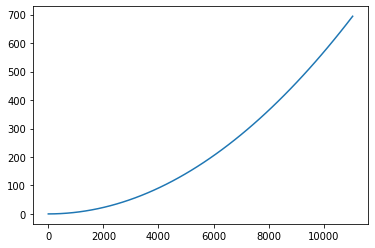

In [112]:
plt.plot(x0, z0)
plt.show()

In [113]:
rng = np.random.default_rng(seed=29)
q0=np.zeros(12*node_N)

In [114]:
for j in range(1,12):
    if j==1:  
        q0[(j-1)*node_N:j*node_N]=x0
    elif j==5:    
        q0[(j-1)*node_N:j*node_N]=z0

In [115]:
def static_func(Q): # here
    t=0
 
    x,y,z=Q[0:node_N],Q[2*node_N:3*node_N],Q[4*node_N:5*node_N]
    dx,dy,dz=Q[1*node_N:2*node_N],Q[3*node_N:4*node_N],Q[5*node_N:6*node_N]
    φ,θ,ψ=Q[6*node_N:7*node_N],Q[8*node_N:9*node_N],Q[10*node_N:11*node_N]
    Ret = Re_t(φ,θ,ψ)

    
    dφ,dθ,dψ=Q[7*node_N:8*node_N],Q[9*node_N:10*node_N],Q[11*node_N:12*node_N]
    
    η=[x[-1],y[-1],z[-1],φ[-1],θ[-1],ψ[-1]]
    
    tau_force=np.array([-Fx_0,0,0,0,0,0])
    Z0=np.dot(Re_b(Ret),tau_force[:3])
    Z1 = d_s(ne, x, y, z, Ret, ωe(φ,θ,ψ,None,None,None)).T
#     test=np.einsum('ijk,ik->ij',Π(φ,θ,ψ).astype(np.float64),np.array([dφ,dθ,dψ]).astype(np.float64).T)

#     Z1 = d_s(ne, x, y, z, Ret, test).T
    DT_0=np.zeros((3,3))
    Z2=ne_(dx,dy,dz,DT_0,Ret).T
    
    
    Z =  Z1 + Z2 + Z0
    
    
############################################################ 
    ddx,ddy, ddz = np.linalg.solve(np.einsum('i,ijk->ijk',M_totl,Re_b(Ret)),Z).T
    ddx,ddy, ddz = np.einsum('ijk,ik->ij',Ret, np.stack([ddx, ddy,ddz], axis=0).T).T

############################################################ 

    sum_0123=0
    lll=[]
    for i in range(1,len(z0)):
        sum_0123=math.sqrt((x[i]-x[i-1])**2+(y[i]-y[i-1])**2+(z[i]-z[i-1])**2)
        lll.append(sum_0123)
        
    cum_d_inv=[0]
    sum_=0
    for i in range(len(lll)-1,-1,-1):
        sum_+=lll[i]
        cum_d_inv.append(sum_)
    cum_d_inv=cum_d_inv[::-1] 
     
    
    Irho=inert(mn, vessel_inertia, Irho_, cum_d_inv, Ws)
    
    
    C0=np.einsum('ijk,kp->ijp',np.einsum('ijk,ikr->ijr',np.linalg.inv(Π(φ,θ,ψ).astype(np.float64)),
                        Re_b(Ret)),tau_force[3:].reshape(3,1)) 
    C3=d_me(φ,θ,ψ,Ret,  ωe,ωe(φ,θ,ψ,None,None,None))
  
    B_ =C3
    B=(B_ + C0.squeeze()
      )

    A2 = Irho_e(Ret,Irho).astype(np.float64)
    A3=Π(φ,θ,ψ).astype(np.float64)
    A=np.einsum('ijk,ikr->ijr',A2,A3)


#############################################
    ddφ,ddθ,ddψ = np.linalg.solve(A,B).T
#############################################

    ans=np.concatenate([dx, ddx, dy, ddy, dz, ddz, dφ, ddφ, dθ, ddθ, dψ, ddψ], axis=0)
  
 
    return ans  

In [116]:
q0

array([0.00000000e+00, 2.25564997e+02, 4.51129994e+02, 6.76694990e+02,
       9.02259987e+02, 1.12782498e+03, 1.35338998e+03, 1.57895498e+03,
       1.80451997e+03, 2.03008497e+03, 2.25564997e+03, 2.48121497e+03,
       2.70677996e+03, 2.93234496e+03, 3.15790996e+03, 3.38347495e+03,
       3.60903995e+03, 3.83460495e+03, 4.06016994e+03, 4.28573494e+03,
       4.51129994e+03, 4.73686493e+03, 4.96242993e+03, 5.18799493e+03,
       5.41355992e+03, 5.63912492e+03, 5.86468992e+03, 6.09025491e+03,
       6.31581991e+03, 6.54138491e+03, 6.76694990e+03, 6.99251490e+03,
       7.21807990e+03, 7.44364490e+03, 7.66920989e+03, 7.89477489e+03,
       8.12033989e+03, 8.34590488e+03, 8.57146988e+03, 8.79703488e+03,
       9.02259987e+03, 9.24816487e+03, 9.47372987e+03, 9.69929486e+03,
       9.92485986e+03, 1.01504249e+04, 1.03759899e+04, 1.06015549e+04,
       1.08271198e+04, 1.10526848e+04, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

In [117]:
root = fsolve(static_func, q0)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


In [118]:
root

array([0.00000000e+00, 2.25564997e+02, 4.51129994e+02, 6.76694990e+02,
       9.02259987e+02, 1.12782498e+03, 1.35338998e+03, 1.57895498e+03,
       1.80451997e+03, 2.03008497e+03, 2.25564997e+03, 2.48121497e+03,
       2.70677996e+03, 2.93234496e+03, 3.15790996e+03, 3.38347495e+03,
       3.60903995e+03, 3.83460495e+03, 4.06016994e+03, 4.28573494e+03,
       4.51129994e+03, 4.73686493e+03, 4.96242993e+03, 5.18799493e+03,
       5.41355992e+03, 5.63912492e+03, 5.86468992e+03, 6.09025491e+03,
       6.31581991e+03, 6.54138491e+03, 6.76694990e+03, 6.99251490e+03,
       7.21807990e+03, 7.44364490e+03, 7.66920989e+03, 7.89477489e+03,
       8.12033989e+03, 8.34590488e+03, 8.57146988e+03, 8.79703488e+03,
       9.02259987e+03, 9.24816487e+03, 9.47372987e+03, 9.69929486e+03,
       9.92485986e+03, 1.01504249e+04, 1.03759899e+04, 1.06015549e+04,
       1.08271198e+04, 1.10526848e+04, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

In [119]:
x0_,z0_=root[:node_N],root[4*node_N:5*node_N]

In [120]:
x0

[0.0,
 225.56499682574736,
 451.1299936514947,
 676.6949904772421,
 902.2599873029894,
 1127.8249841287368,
 1353.3899809544841,
 1578.9549777802315,
 1804.5199746059789,
 2030.0849714317262,
 2255.6499682574736,
 2481.2149650832207,
 2706.7799619089683,
 2932.344958734716,
 3157.909955560463,
 3383.47495238621,
 3609.0399492119577,
 3834.6049460377053,
 4060.1699428634524,
 4285.7349396892,
 4511.299936514947,
 4736.864933340695,
 4962.429930166441,
 5187.994926992189,
 5413.559923817937,
 5639.124920643684,
 5864.689917469432,
 6090.254914295178,
 6315.819911120926,
 6541.384907946674,
 6766.94990477242,
 6992.514901598168,
 7218.079898423915,
 7443.644895249663,
 7669.209892075411,
 7894.774888901157,
 8120.339885726905,
 8345.904882552652,
 8571.4698793784,
 8797.034876204147,
 9022.599873029894,
 9248.164869855642,
 9473.72986668139,
 9699.294863507137,
 9924.859860332883,
 10150.42485715863,
 10375.989853984378,
 10601.554850810126,
 10827.119847635873,
 11052.68484446162]

In [121]:
x0_

array([    0.        ,   225.56499683,   451.12999365,   676.69499048,
         902.2599873 ,  1127.82498413,  1353.38998095,  1578.95497778,
        1804.51997461,  2030.08497143,  2255.64996826,  2481.21496508,
        2706.77996191,  2932.34495873,  3157.90995556,  3383.47495239,
        3609.03994921,  3834.60494604,  4060.16994286,  4285.73493969,
        4511.29993651,  4736.86493334,  4962.42993017,  5187.99492699,
        5413.55992382,  5639.12492064,  5864.68991747,  6090.2549143 ,
        6315.81991112,  6541.38490795,  6766.94990477,  6992.5149016 ,
        7218.07989842,  7443.64489525,  7669.20989208,  7894.7748889 ,
        8120.33988573,  8345.90488255,  8571.46987938,  8797.0348762 ,
        9022.59987303,  9248.16486986,  9473.72986668,  9699.29486351,
        9924.85986033, 10150.42485716, 10375.98985398, 10601.55485081,
       10827.11984764, 11052.68484446])

In [122]:
z0

[0.0,
 0.2888428427924309,
 1.155373265710624,
 2.5995969523577234,
 4.621523375418674,
 7.221165796797117,
 10.398541267595833,
 14.15367062831231,
 18.486578508975636,
 23.39729332924428,
 28.885847298621222,
 34.95227641670818,
 41.59662047340119,
 48.81892304912524,
 56.619231515186364,
 64.99759703402582,
 73.9540745596112,
 83.48872283771031,
 93.60160440638002,
 104.29278559627915,
 115.56233653119654,
 127.41033112846175,
 139.83684709937523,
 152.8419659498538,
 166.4257729808412,
 180.58835728891447,
 195.3298117668901,
 210.65023310439128,
 226.54972178849314,
 243.02838210444648,
 260.0863221362252,
 277.72365376736735,
 295.94049268164,
 314.7369583638412,
 334.1131741005232,
 354.0692669808534,
 374.60536789741576,
 395.72161154711085,
 417.41813643197673,
 439.6950848601867,
 462.5526029468705,
 485.9908406151509,
 510.0099515971214,
 534.6100934348437,
 559.7914274813454,
 585.5541189017534,
 611.8983366742727,
 638.8242535914375,
 666.3320462610891,
 694.4218951076863]

In [123]:
z0_

array([0.00000000e+00, 2.88842843e-01, 1.15537327e+00, 2.59959695e+00,
       4.62152338e+00, 7.22116580e+00, 1.03985413e+01, 1.41536706e+01,
       1.84865785e+01, 2.33972933e+01, 2.88858473e+01, 3.49522764e+01,
       4.15966205e+01, 4.88189230e+01, 5.66192315e+01, 6.49975970e+01,
       7.39540746e+01, 8.34887228e+01, 9.36016044e+01, 1.04292786e+02,
       1.15562337e+02, 1.27410331e+02, 1.39836847e+02, 1.52841966e+02,
       1.66425773e+02, 1.80588357e+02, 1.95329812e+02, 2.10650233e+02,
       2.26549722e+02, 2.43028382e+02, 2.60086322e+02, 2.77723654e+02,
       2.95940493e+02, 3.14736958e+02, 3.34113174e+02, 3.54069267e+02,
       3.74605368e+02, 3.95721612e+02, 4.17418136e+02, 4.39695085e+02,
       4.62552603e+02, 4.85990841e+02, 5.10009952e+02, 5.34610093e+02,
       5.59791427e+02, 5.85554119e+02, 6.11898337e+02, 6.38824254e+02,
       6.66332046e+02, 6.94421895e+02])

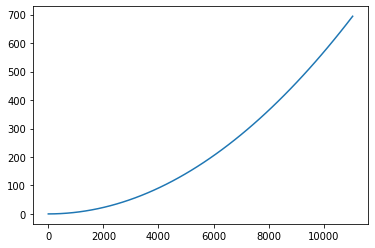

In [124]:
plt.plot(x0_, z0_)
plt.show()

In [125]:
init=1e-20
for j in range(1,12):
    if j==1:  
        q0[(j-1)*node_N:j*node_N]=x0_
    elif j==5:    
        q0[(j-1)*node_N:j*node_N]=z0_
#     elif j==9:    
#         q0[(j-1)*node_N:j*node_N]=init*rng.standard_normal(node_N)
#         q0[(j-1)*node_N]=0
#     elif j==11:   
#         q0[(j-1)*node_N:j*node_N]=init*rng.standard_normal(node_N)
#         q0[(j-1)*node_N]=0
    elif j==9:    
        q0[(j-1)*node_N:j*node_N]=np.array([-0.001*init for i in range(node_N)])
        q0[(j-1)*node_N]=0
    elif j==11:   
        q0[(j-1)*node_N:j*node_N]=np.array([-0.001*init for i in range(node_N)])
        q0[(j-1)*node_N]=0 
# q0[9*node_N-1]=0.13  # here

In [126]:
q0

array([ 0.00000000e+00,  2.25564997e+02,  4.51129994e+02,  6.76694990e+02,
        9.02259987e+02,  1.12782498e+03,  1.35338998e+03,  1.57895498e+03,
        1.80451997e+03,  2.03008497e+03,  2.25564997e+03,  2.48121497e+03,
        2.70677996e+03,  2.93234496e+03,  3.15790996e+03,  3.38347495e+03,
        3.60903995e+03,  3.83460495e+03,  4.06016994e+03,  4.28573494e+03,
        4.51129994e+03,  4.73686493e+03,  4.96242993e+03,  5.18799493e+03,
        5.41355992e+03,  5.63912492e+03,  5.86468992e+03,  6.09025491e+03,
        6.31581991e+03,  6.54138491e+03,  6.76694990e+03,  6.99251490e+03,
        7.21807990e+03,  7.44364490e+03,  7.66920989e+03,  7.89477489e+03,
        8.12033989e+03,  8.34590488e+03,  8.57146988e+03,  8.79703488e+03,
        9.02259987e+03,  9.24816487e+03,  9.47372987e+03,  9.69929486e+03,
        9.92485986e+03,  1.01504249e+04,  1.03759899e+04,  1.06015549e+04,
        1.08271198e+04,  1.10526848e+04,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  

### Vessle Simulation

In [127]:
sampleTime = 0.01              # sample time [seconds]
N = 5000                      # number of samples

In [128]:
vehicle=semisub('DPcontrol',0,5,40.0,0,0) 

In [129]:
[simTime, simData] = simulate(N, sampleTime, vehicle)

In [130]:
ans_t=[]
sum_=0
for i in range(simData.shape[0]):
    ans_t.append(sum_)
    sum_+=sampleTime

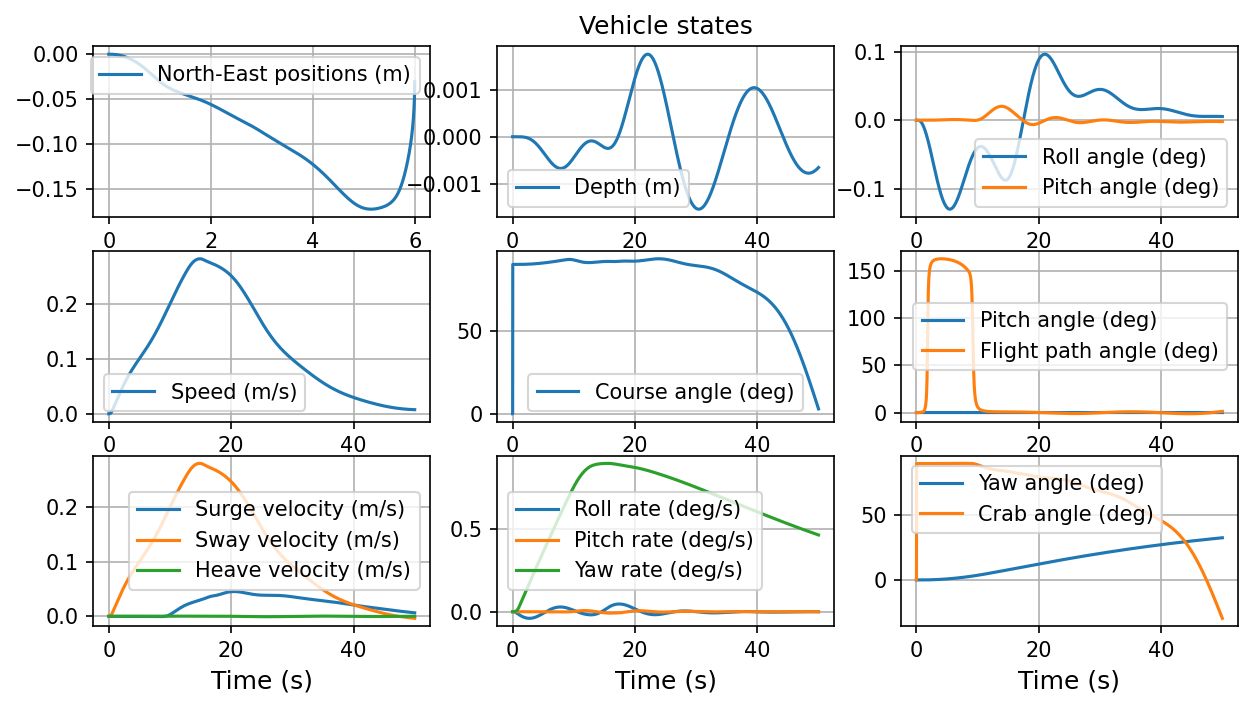

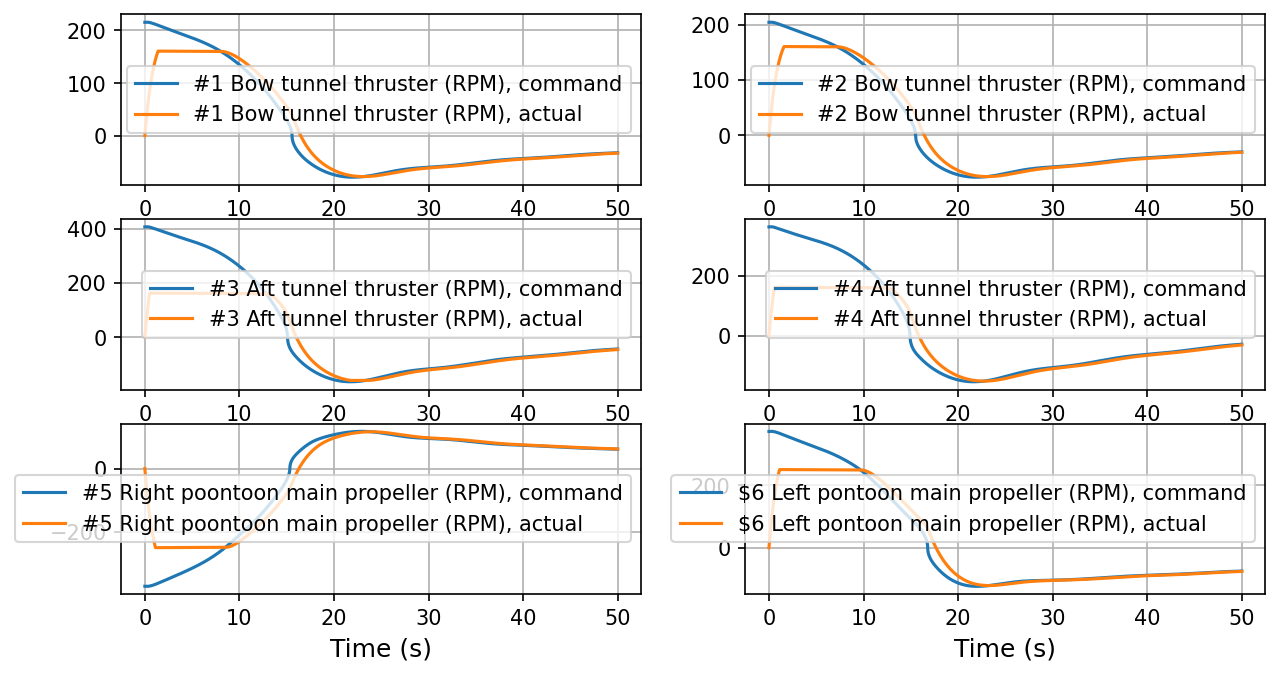

In [131]:
plotVehicleStates(simTime, simData, 1)                    
plotControls(simTime, simData, vehicle, 2)

In [132]:
numDataPoints = 5                 # number of 3D data points
FPS = 10                            # frames per second (animated GIF)
filename = '3D_animation.gif'       # data file for animated GIF
browser = 'safari'       

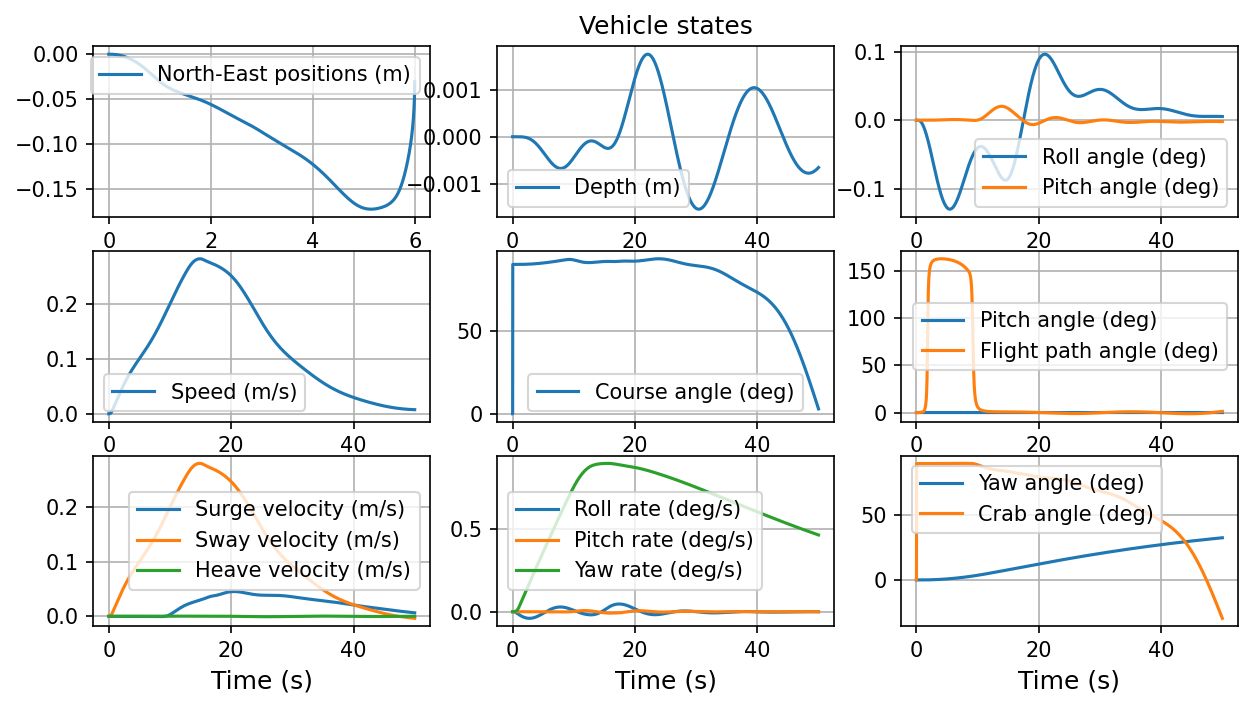

In [133]:
plotVehicleStates(simTime, simData, 3)

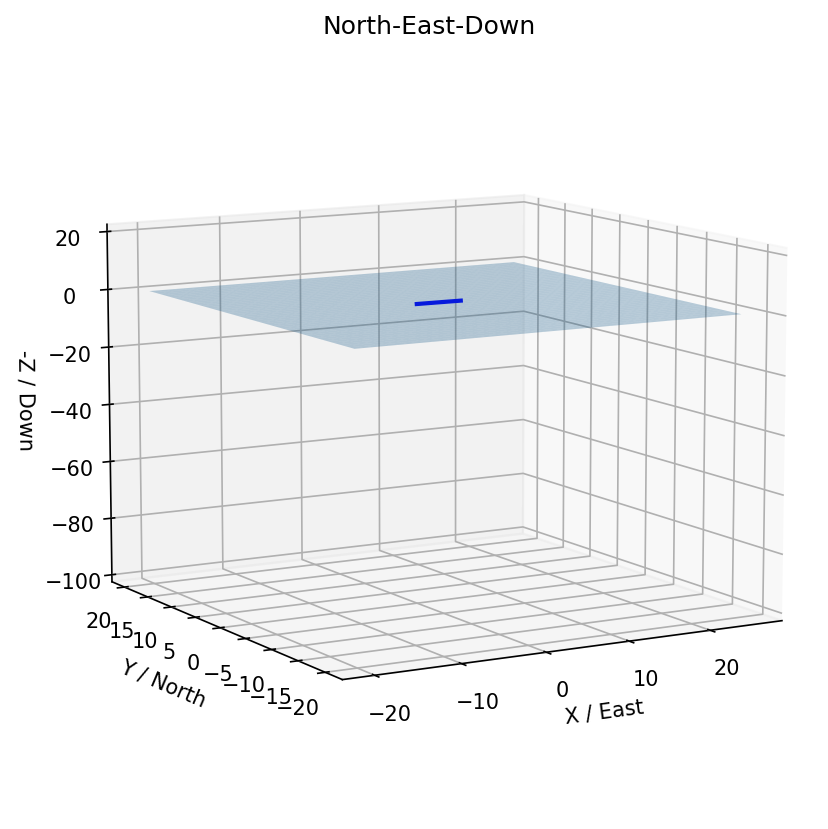

In [134]:
plot3D(simData, numDataPoints, FPS, filename, 3)  

In [135]:
def myDPcontrol(self, eta, nu, sampleTime):
        """
        u = DPcontrol(eta,nu,sampleTime) is a nonlinear PID controller
        for DP based on pole placement:

        tau = -R' Kp (eta-r) - R' Kd R nu - R' Ki int(eta-r)
        u = B_pseudoinverse * tau
        """
        # 3-DOF state vectors
        eta3 = np.array([eta[0], eta[1], eta[5]])
        nu3 = np.array([nu[0], nu[1], nu[5]])

        # 3-DOF diagonal model matrices
        M3 = np.diag([self.M[0][0], self.M[1][1], self.M[5][5]])
        D3 = np.diag([self.D[0][0], self.D[1][1], self.D[5][5]])

        [tau3, self.e_int, self.x_d, self.y_d, self.psi_d] = DPpolePlacement(
            self.e_int,
            M3,
            D3,
            eta3,
            nu3,
            self.x_d,
            self.y_d,
            self.psi_d,
            self.wn,
            self.zeta,
            self.ref,
            sampleTime,
        )
        
        tau=list(tau3)+[tau3[2]*ly - tau3[1]*lz,
                  tau3[0]*lz - tau3[2]*lx,
                  tau3[1]*lx - tau3[0]*ly]

#         u_alloc = self.controlAllocation(tau3)
        return tau

In [136]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

In [137]:
# Ws[0]*Ret[2]

In [138]:
# np.einsum('i,ijk->ijk',[Ws[i] for i in range(node_N)],Ret)

### Dynamics

In [139]:
def grayscott1d(t, Q): # here
#     print(t)
      
    x,y,z=Q[0:node_N],Q[2*node_N:3*node_N],Q[4*node_N:5*node_N]
    
    idx = find_nearest(np.array(ans_t),  t) 

    x_ve = simData[:, 0][idx]
    y_ve = simData[:, 1][idx]
#     x_ve = simData[:, 1][idx]
#     y_ve = simData[:, 0][idx]
    z_ve = simData[:, 2][idx]
    phi_ve = ssa(simData[:, 3][idx])
    theta_ve = ssa(simData[:, 4][idx])
    psi_v = ssa(simData[:, 5][idx])
    
    
    u_ve = simData[:, 6][idx]
    v_ve = simData[:, 7][idx]
#     u_ve = simData[:, 7][idx]
#     v_ve = simData[:, 6][idx]
    w_ve = simData[:, 8][idx]
    p_ve = simData[:, 9][idx]
    q_ve = simData[:, 10][idx]
    r_ve = simData[:, 11][idx]
    
    
    η=np.array([x_ve, y_ve, z_ve, phi_ve, theta_ve, psi_v])
    
    dη=np.array([u_ve, v_ve, w_ve, p_ve, q_ve, r_ve])
    
    
#     n_ = vehicle.DPcontrol(η,dη,sampleTime) # /1e3
    n_ = myDPcontrol(vehicle,η,dη,sampleTime)
#     print(n_)
    

    dx,dy,dz=Q[1*node_N:2*node_N],Q[3*node_N:4*node_N],Q[5*node_N:6*node_N]
    

    φ,θ,ψ=Q[6*node_N:7*node_N],Q[8*node_N:9*node_N],Q[10*node_N:11*node_N]
#     φ[-1],θ[-1],ψ[-1]=phi_ve, theta_ve,psi_v
    Ret = Re_t(φ,θ,ψ)
#     print(Ret)

    dφ,dθ,dψ=Q[7*node_N:8*node_N],Q[9*node_N:10*node_N],Q[11*node_N:12*node_N]
    
#     force_schedule =1/(1+np.exp(-np.exp(t/10)+np.exp(2)))
#     force_schedule = t/15 if t<15 else 1
#     force_schedule = 1e-1000
#     force_schedule=100
    force_schedule=1e-10
#     force_schedule=0
#     print(type(n_))
    tau_force = force_schedule*np.array(n_) # [N]
#     tau_force[0]=0
#     tau_force[1]=0
#     tau_force[2]=0
#     tau_force[3]=0
#     tau_force[4]=0
#     tau_force[5]=0

#     print(tau_force[:3])
    Z0=-np.dot(Re_b(Ret),tau_force[:3])
#     print(Ret)
#     print(Z0)
#     print(Z0)
    Z1 =d_s(ne, x, y, z, Ret,  ωe(φ,θ,ψ,None,None,None)).T
#     Z1 =d_s(ne, x, y, z, Ret, phi(x,y,z,Ret,None)).T
#     print(Z1)
    Z2=ne_(dx,dy,dz,DT,Ret).T
#     print(Z0)

    Z= (Z1 + Z2 +Z0
       )
#     Z[-1]+=tau_force[:3]

############################################################    
#     print(Ws)
    RRRR=Re_b(Ret)
#     print(Ret)
    ddx,ddy, ddz = np.linalg.solve(np.einsum('i,ijk->ijk',
                                             [Ws[i] for i in range(node_N)]
#                                              +[Ws[-1] + vessel_mass]
#                                              M_totl
                                          
                                             ,RRRR),
                                   Z
                                  ).T 
#     print(ddx)
#     print(np.concatenate([ddx, ddy,ddz, dφ,], axis=0))
#     ddx,ddy, ddz = Ret
    ddx,ddy, ddz = np.einsum('ijk,ik->ij',Ret, np.stack([ddx, ddy,ddz], axis=0).T).T
#     print(ddx)
#     print()
############################################################      

    sum_0123=0
    lll=[]
    for i in range(1,len(z0)):
        sum_0123=math.sqrt((x[i]-x[i-1])**2+(y[i]-y[i-1])**2+(z[i]-z[i-1])**2)
        lll.append(sum_0123)
#     print(lll)    
        
    cum_d_inv=[0]
    sum_=0
    for i in range(len(lll)-1,-1,-1):
        sum_+=lll[i]
        cum_d_inv.append(sum_)
    cum_d_inv=cum_d_inv[::-1]   
    
    Irho=inert(mn, vessel_inertia, Irho_, cum_d_inv, Ws)
#     print(Irho)
#     print()
 
    
 

    C1=np.einsum('ijk,ik->ij', Irho_e(Ret,Irho).astype(np.float64),
                                                        np.einsum('ijk,ik->ij', Π(dφ,dθ,dψ).astype(np.float64), 
                                                                  np.array([dφ,dθ,dψ]).astype(np.float64).T))
    
    test=np.einsum('ijk,ik->ij',Π(φ,θ,ψ).astype(np.float64),np.array([dφ,dθ,dψ]).astype(np.float64).T)
  
    C2= np.cross(
         test,
                 np.einsum('ijk,ik->ij',Irho_e(Ret,Irho).astype(np.float64),
                            test))


    C3=d_me(φ,θ,ψ,Ret, ωe, ωe(φ,θ,ψ,None,None,None))
#     print(C3)
    
#     C4= np.cross(d_s(phi,x,y,z,Ret, phi(x,y,z,Ret,None)).T, ne(x,y,z,Ret, phi(x,y,z,Ret,None)))
    C4= np.cross(d_s(phi,x,y,z,Ret, ωe(φ,θ,ψ,None,None,None)).T, 
                 ne(x,y,z,Ret, ωe(φ,θ,ψ,None,None,None),None))
#     print(C4)
#     print(tau_force[:3])
#     C4= np.cross(d_s(phi,x,y,z,Ret, test).T, ne(x,y,z,Ret, test))
    
    K1=test.T

    C5= np.einsum('ijk,ik->ij',Ret, -np.dot(DR,K1).astype(np.float64).T)

    C0=-np.einsum('ijk,kp->ijp',np.einsum('ijk,ikr->ijr',np.linalg.inv(Π(φ,θ,ψ).astype(np.float64)),
                        Re_b(Ret)),tau_force[3:].reshape(3,1)) 
    B_ =(
        -C1
        -C2
        +C3
        +C4
        +C5
    )
    B= B_ +C0.squeeze()
#     print(C0,C1,C2,C3,C4)



#     print(B)   
    
#     print(Irho_e(Ret,Irho))
    A2 = Irho_e(Ret,Irho).astype(np.float64)
    A3=Π(φ,θ,ψ).astype(np.float64)

    A=np.einsum('ijk,ikr->ijr',A2,A3)
    

#     hack=1e18
    hack=1
############################################
    ddφ,ddθ,ddψ = np.linalg.solve(hack*A,B).T
#############################################


#     ddx[0],ddy[0],ddz[0],ddφ[0],ddθ[0],ddψ[0]=0,0,0,0,0,0
    A1111=np.concatenate([dx, ddx, dy, ddy, dz, ddz, dφ, ddφ, dθ, ddθ, dψ, ddψ], axis=0)
#     print(A1111)
    return A1111

In [140]:
# import scipy

In [141]:
# ode15s = scipy.integrate.ode(grayscott1d)
# ode15s.set_integrator('vode', method='bdf', order=15, nsteps=3000)
# # ode15s.set_integrator('vode',  order=32, nsteps=3000)
# ode15s.set_initial_value(q0, 0)

In [142]:
# us=ode15s.integrate(10)

In [171]:

tspan = (0., 0.5)

In [172]:
startTime1 = datetime.now()

us=solve_ivp(grayscott1d,  tspan, q0, 
#              nfev=842
#              method='LSODA',
#              method= 'BDF'
#              vectorized=True
#              min_step=1e-6
#              rtol=1e9, atol=1e9
            )
print(datetime.now() - startTime1)

0:00:03.306859


In [173]:
# key takeaway: one can calibrate the model by tuning bc(init) and force_schedule 

### Results

In [174]:
fin=us

In [175]:
fin

  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 164
     njev: 0
      nlu: 0
      sol: None
   status: 0
  success: True
        t: array([0.        , 0.01028418, 0.11312599, 0.2470741 , 0.32514042,
       0.37614953, 0.41870801, 0.43615263, 0.45359726, 0.46435629,
       0.47511533, 0.48371052, 0.48896471, 0.49218054, 0.49539636,
       0.49701912, 0.49864188, 0.5       ])
 t_events: None
        y: array([[ 0.00000000e+00, -3.71196937e-13, -4.49148677e-11, ...,
        -8.67261945e-10, -8.72937864e-10, -8.77702404e-10],
       [ 2.25564997e+02,  2.25564997e+02,  2.25564997e+02, ...,
         2.25564997e+02,  2.25564997e+02,  2.25564997e+02],
       [ 4.51129994e+02,  4.51129994e+02,  4.51129994e+02, ...,
         4.51129994e+02,  4.51129994e+02,  4.51129994e+02],
       ...,
       [ 0.00000000e+00, -3.25698105e-14, -8.31987864e-12, ...,
        -4.05566361e-03, -4.43029474e-03, -4.77029077e-03],
       [ 0.00000000e+00, -3.20210836e-14,

In [176]:
t=fin.t

In [177]:
fin=fin.y.T

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  


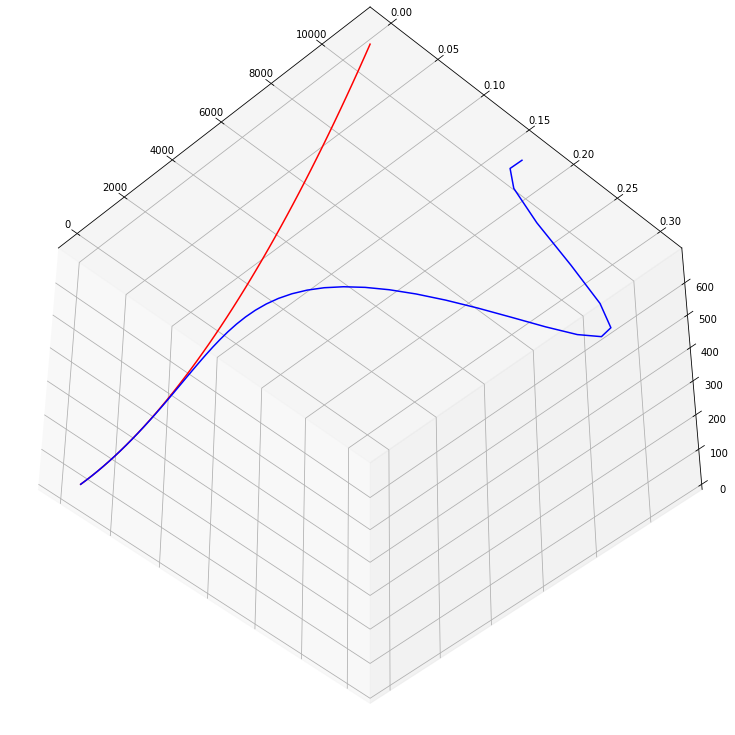

In [178]:
fig=plt.figure(figsize=(13,13))
ax = fig.gca(projection='3d')

X0=fin[0,[i for i in range(0,node_N)]]
Y0=fin[0,[i for i in range(2*node_N,3*node_N)]]
Z0=fin[0,[i for i in range(4*node_N,5*node_N)]]

j=-1
X=fin[j,[i for i in range(0,node_N)]]
Y=fin[j,[i for i in range(2*node_N,3*node_N)]]
Z=fin[j,[i for i in range(4*node_N,5*node_N)]]

num_true_pts = 200
tck, u = interpolate.splprep([X,Y,Z], s=2)
u_fine = np.linspace(0,1,num_true_pts)
x_fine, y_fine, z_fine = interpolate.splev(u_fine, tck)


ax.plot(X0,Y0,Z0, color='r')
ax.plot(X,Y,Z, color='b') 
# ax.plot(x_fine, y_fine, z_fine, color='b')
ax.view_init(-45,-45)

# ax.view_init(0,-90)
plt.show()

In [179]:
X,Y,Z

(array([-8.77702404e-10,  2.25564997e+02,  4.51129994e+02,  6.76694990e+02,
         9.02259987e+02,  1.12782498e+03,  1.35338998e+03,  1.57895498e+03,
         1.80451997e+03,  2.03008497e+03,  2.25564997e+03,  2.48121497e+03,
         2.70677996e+03,  2.93234496e+03,  3.15790996e+03,  3.38347495e+03,
         3.60903995e+03,  3.83460495e+03,  4.06016994e+03,  4.28573494e+03,
         4.51129994e+03,  4.73686493e+03,  4.96242993e+03,  5.18799492e+03,
         5.41355991e+03,  5.63912490e+03,  5.86468987e+03,  6.09025483e+03,
         6.31581975e+03,  6.54138462e+03,  6.76694939e+03,  6.99251398e+03,
         7.21807827e+03,  7.44364207e+03,  7.66920502e+03,  7.89476660e+03,
         8.12032595e+03,  8.34588178e+03,  8.57143219e+03,  8.79697454e+03,
         9.02250539e+03,  9.24802036e+03,  9.47351358e+03,  9.69897567e+03,
         9.92439082e+03,  1.01497381e+04,  1.03750028e+04,  1.06001859e+04,
         1.08252959e+04,  1.10503288e+04]),
 array([-2.02223652e-07,  1.11117344e-07,  6

In [180]:
X0,Y0,Z0

(array([    0.        ,   225.56499683,   451.12999365,   676.69499048,
          902.2599873 ,  1127.82498413,  1353.38998095,  1578.95497778,
         1804.51997461,  2030.08497143,  2255.64996826,  2481.21496508,
         2706.77996191,  2932.34495873,  3157.90995556,  3383.47495239,
         3609.03994921,  3834.60494604,  4060.16994286,  4285.73493969,
         4511.29993651,  4736.86493334,  4962.42993017,  5187.99492699,
         5413.55992382,  5639.12492064,  5864.68991747,  6090.2549143 ,
         6315.81991112,  6541.38490795,  6766.94990477,  6992.5149016 ,
         7218.07989842,  7443.64489525,  7669.20989208,  7894.7748889 ,
         8120.33988573,  8345.90488255,  8571.46987938,  8797.0348762 ,
         9022.59987303,  9248.16486986,  9473.72986668,  9699.29486351,
         9924.85986033, 10150.42485716, 10375.98985398, 10601.55485081,
        10827.11984764, 11052.68484446]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.

In [181]:
us=fin.T

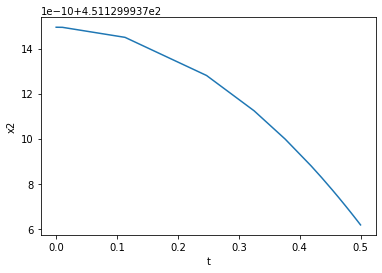

In [182]:
plt.plot(t,us.T[:,2],'-')
plt.xlabel('t')
plt.ylabel('x2')
plt.show()

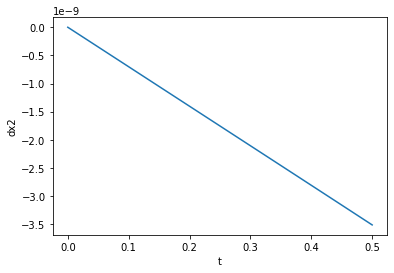

In [183]:
plt.plot(t,us.T[:,node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dx2')
plt.show()

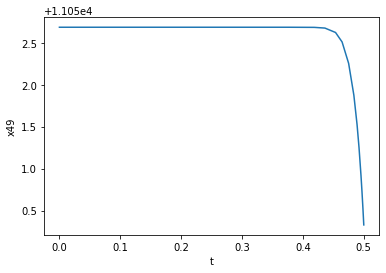

In [184]:
plt.plot(t,us.T[:,node_N-1] ,'-')
plt.xlabel('t')
plt.ylabel('x49')
plt.show()

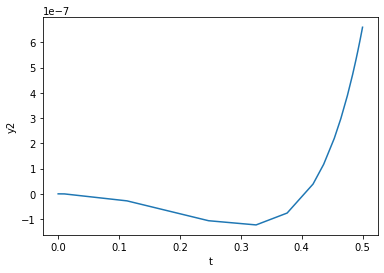

In [185]:
plt.plot(t,us.T[:,2*node_N +2] ,'-')
plt.xlabel('t')
plt.ylabel('y2')
plt.show()

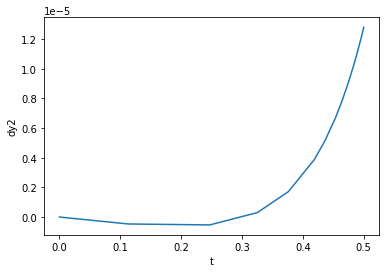

In [186]:
plt.plot(t,us.T[:,3*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dy2')
plt.show()

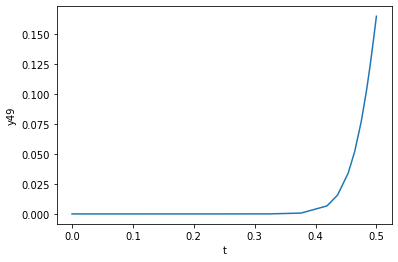

In [187]:
plt.plot(t,us.T[:,2*node_N+49] ,'-')
plt.xlabel('t')
plt.ylabel('y49')
plt.show()

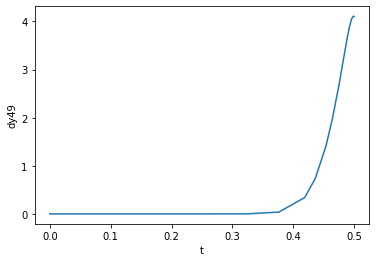

In [188]:
plt.plot(t,us.T[:,3*node_N+49] ,'-')
plt.xlabel('t')
plt.ylabel('dy49')
plt.show()

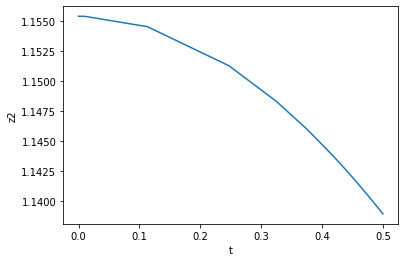

In [189]:
plt.plot(t,us.T[:,4*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('z2')
plt.show()

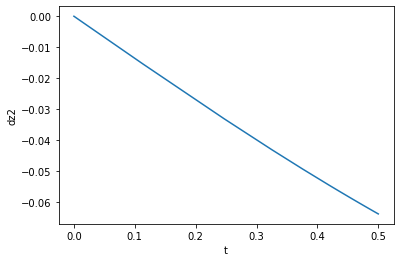

In [190]:
plt.plot(t,us.T[:,5*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dz2')
plt.show()

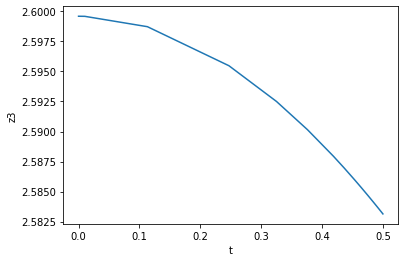

In [191]:
plt.plot(t,us.T[:,4*node_N+3] ,'-')
plt.xlabel('t')
plt.ylabel('z3')
plt.show()

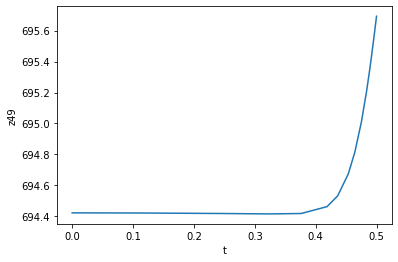

In [192]:
plt.plot(t,us.T[:,4*node_N+49] ,'-')
plt.xlabel('t')
plt.ylabel('z49')
plt.show()

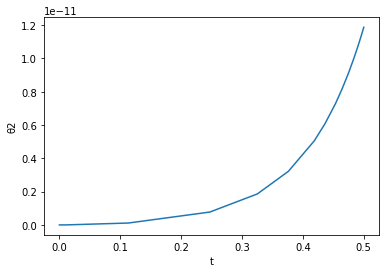

In [193]:
plt.plot(t,us.T[:,8*node_N+2],'-')
plt.xlabel('t')
plt.ylabel('θ2')
plt.show()

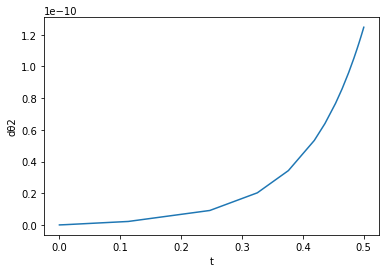

In [194]:
plt.plot(t,us.T[:,9*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dθ2')
plt.show()

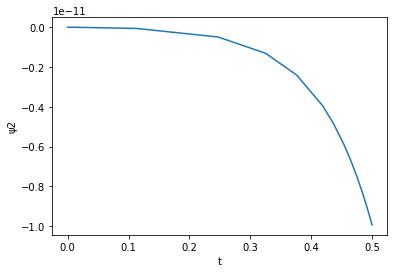

In [195]:
plt.plot(t,us.T[:,10*node_N+2],'-')
plt.xlabel('t')
plt.ylabel('ψ2')
plt.show()

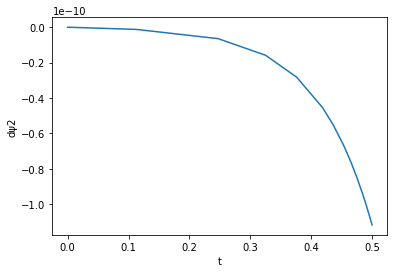

In [196]:
plt.plot(t,us.T[:,11*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dψ2')
plt.show()